# Cointegration Analysis: Crypto Assets vs Traditional Asset Classes

This notebook investigates long-run equilibrium relationships between major crypto assets (BTC, ETH, SOL) and traditional asset classes, and tests whether these relationships are stable across different market regimes.

**Key Questions:**
1. Do long-run equilibrium relationships exist between major crypto assets and traditional asset classes?
2. Are these relationships stable across market regimes?

---


In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Cointegration tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Directories
MASTER_CSV = "../1_data/historical_prices.csv"
OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures")
TABLE_DIR = os.path.join(OUT_DIR, "tables")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

# Asset definitions
CRYPTO_ASSETS = ["BTC-USD", "ETH-USD", "SOL-USD"]
TRAD_ASSETS = ["IEF", "^RUT", "^SPX", "DBC", "VNQ"]  # Using ^SPX as SPY equivalent
REGIME_INDICATORS = ["^VIX", "^SPX"]

print("Libraries imported successfully")


Libraries imported successfully


## 1. Setup and Data Loading

Import libraries, define assets, and load historical price data.


In [22]:
# Load and prepare data
def read_master_csv(path: str) -> pd.DataFrame:
    """Read master CSV and parse DATE index"""
    df = pd.read_csv(path)
    
    if "DATE" not in df.columns:
        df.rename(columns={df.columns[0]: "DATE"}, inplace=True)
    
    df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
    bad = df["DATE"].isna().mean()
    if bad > 0.2:
        df["DATE"] = pd.to_datetime(df["DATE"], format="%m/%d/%Y", errors="coerce")
    
    df = df.dropna(subset=["DATE"]).set_index("DATE").sort_index()
    
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    
    return df

# Load data
master = read_master_csv(MASTER_CSV)

# Extract relevant assets (remove duplicates)
all_assets = CRYPTO_ASSETS + TRAD_ASSETS + REGIME_INDICATORS
available_assets = list(dict.fromkeys([a for a in all_assets if a in master.columns]))  # Preserve order, remove dupes

print(f"Available assets: {available_assets}")
print(f"Missing assets: {set(all_assets) - set(available_assets)}")

# Get price data for analysis - remove duplicate columns if any
prices = master[available_assets].copy()
prices = prices.loc[:, ~prices.columns.duplicated()]  # Remove duplicate columns

# Filter to dates where all required assets have data
required_assets = list(dict.fromkeys(CRYPTO_ASSETS + TRAD_ASSETS + ["^VIX", "^SPX"]))  # Remove dupes
prices = prices[required_assets].dropna()

print(f"\nData shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
print(f"Total trading days: {len(prices)}")

# Calculate log prices for cointegration tests
log_prices = np.log(prices)
returns = prices.pct_change().dropna()
log_returns = log_prices.diff().dropna()

print(f"\nLog prices shape: {log_prices.shape}")
print(f"Returns shape: {returns.shape}")


Available assets: ['BTC-USD', 'ETH-USD', 'SOL-USD', 'IEF', '^RUT', '^SPX', 'DBC', 'VNQ', '^VIX']
Missing assets: set()

Data shape: (1397, 9)
Date range: 2020-04-13 00:00:00 to 2025-10-30 00:00:00
Total trading days: 1397

Log prices shape: (1397, 9)
Returns shape: (1396, 9)


---

## 2. Cointegration Tests

### 2.1 Engle-Granger Cointegration Test

Pairwise cointegration tests between each crypto asset and each traditional asset.


### 2.2 Johansen Cointegration Test

Multivariate cointegration tests for each crypto asset with all traditional assets combined.


In [23]:
# Engle-Granger Cointegration Test
def engle_granger_test(y, x, maxlag=None):
    """
    Engle-Granger two-step cointegration test
    
    Returns:
        tuple: (test_statistic, p_value, cointegrating_vector)
    """
    # Step 1: OLS regression
    X = sm.add_constant(x)
    model = OLS(y, X).fit()
    residuals = model.resid
    
    # Step 2: ADF test on residuals
    adf_result = adfuller(residuals, maxlag=maxlag, autolag='AIC')
    
    # Extract cointegrating vector: y = alpha + beta*x
    alpha = model.params['const']
    beta = model.params[x.name] if hasattr(x, 'name') else model.params.iloc[1]
    
    return {
        'adf_statistic': adf_result[0],
        'p_value': adf_result[1],
        'critical_values': adf_result[4],
        'alpha': alpha,
        'beta': beta,
        'residuals': residuals
    }

# Test all pairs: Crypto vs Traditional assets
eg_results = []

for crypto in CRYPTO_ASSETS:
    if crypto not in log_prices.columns:
        continue
    for trad in TRAD_ASSETS:
        if trad not in log_prices.columns:
            continue
        
        # Get aligned data
        data = log_prices[[crypto, trad]].dropna()
        if len(data) < 100:  # Need sufficient data
            continue
        
        y = data[crypto]
        x = data[trad]
        
        try:
            result = engle_granger_test(y, x)
            eg_results.append({
                'Crypto': crypto,
                'Traditional': trad,
                'ADF_Statistic': result['adf_statistic'],
                'P_Value': result['p_value'],
                'Cointegrated': result['p_value'] < 0.05,
                'Alpha': result['alpha'],
                'Beta': result['beta'],
                'Observations': len(data)
            })
        except Exception as e:
            print(f"Error testing {crypto} vs {trad}: {e}")

eg_df = pd.DataFrame(eg_results)
print("\n=== Engle-Granger Cointegration Test Results ===\n")
print(eg_df.round(4))

# Save results
eg_df.to_csv(os.path.join(TABLE_DIR, "engle_granger_results.csv"), index=False)



=== Engle-Granger Cointegration Test Results ===

     Crypto Traditional  ADF_Statistic  P_Value  Cointegrated    Alpha  \
0   BTC-USD         IEF        -1.5155   0.5258         False  22.9723   
1   BTC-USD        ^RUT        -3.1728   0.0216          True -21.0096   
2   BTC-USD        ^SPX        -2.9354   0.0414          True -16.7881   
3   BTC-USD         DBC        -1.2686   0.6434         False   5.6875   
4   BTC-USD         VNQ        -2.4652   0.1242         False  -9.1411   
5   ETH-USD         IEF        -2.6182   0.0893         False  27.9547   
6   ETH-USD        ^RUT        -2.4663   0.1239         False -27.1978   
7   ETH-USD        ^SPX        -2.0427   0.2682         False -18.0109   
8   ETH-USD         DBC        -2.4048   0.1404         False   0.2933   
9   ETH-USD         VNQ        -3.6759   0.0045          True -15.7300   
10  SOL-USD         IEF        -1.7237   0.4189         False  51.3808   
11  SOL-USD        ^RUT        -2.4178   0.1368         False

### 2.3 Comprehensive Cointegration Results

Combine Engle-Granger and Johansen test results into a single summary table.


In [24]:
# Johansen Cointegration Test
def johansen_test(data, det_order=0, k_ar_diff=1):
    """
    Johansen cointegration test for multivariate series
    
    Parameters:
        data: DataFrame with time series
        det_order: 0 = no constant, 1 = constant, -1 = trend
        k_ar_diff: Number of lags for VAR
    """
    try:
        result = coint_johansen(data.values, det_order=det_order, k_ar_diff=k_ar_diff)
        
        # Test statistics and critical values
        trace_stat = result.lr1  # Trace statistic (array)
        eigen_stat = result.lr2  # Eigenvalue statistic (array)
        
        # Critical values: cvt and cvm are (n_vars x 3) arrays with columns for 90%, 95%, 99%
        trace_cv = result.cvt  # Trace critical values
        eigen_cv = result.cvm  # Eigenvalue critical values
        
        # Number of cointegrating relationships
        n_coint = result.r
        
        return {
            'trace_stat': trace_stat,
            'eigen_stat': eigen_stat,
            'trace_cv_90': trace_cv[:, 0],  # 90% CV for each eigenvalue
            'trace_cv_95': trace_cv[:, 1],  # 95% CV for each eigenvalue
            'trace_cv_99': trace_cv[:, 2],  # 99% CV for each eigenvalue
            'eigen_cv_90': eigen_cv[:, 0],
            'eigen_cv_95': eigen_cv[:, 1],
            'eigen_cv_99': eigen_cv[:, 2],
            'n_cointegrating': n_coint,
            'cointegrating_vectors': result.evec[:, :n_coint] if n_coint > 0 else None
        }
    except Exception as e:
        print(f"Johansen test error: {e}")
        return None

# Test each crypto with all traditional assets together
johansen_results = []

for crypto in CRYPTO_ASSETS:
    if crypto not in log_prices.columns:
        continue
    
    # Combine crypto with all traditional assets
    trad_cols = [t for t in TRAD_ASSETS if t in log_prices.columns]
    if len(trad_cols) == 0:
        continue
    
    test_data = log_prices[[crypto] + trad_cols].dropna()
    if len(test_data) < 100:
        continue
    
    try:
        result = johansen_test(test_data, det_order=1, k_ar_diff=1)
        if result:
            # Use first test (testing for at least one cointegrating relationship)
            trace_stat_first = result['trace_stat'][0]
            eigen_stat_first = result['eigen_stat'][0]
            trace_cv_95_first = result['trace_cv_95'][0]
            eigen_cv_95_first = result['eigen_cv_95'][0]
            
            johansen_results.append({
                'Crypto': crypto,
                'Trace_Stat': trace_stat_first,
                'Trace_CV_95': trace_cv_95_first,
                'Eigen_Stat': eigen_stat_first,
                'Eigen_CV_95': eigen_cv_95_first,
                'Cointegrated_Trace': trace_stat_first > trace_cv_95_first,
                'Cointegrated_Eigen': eigen_stat_first > eigen_cv_95_first,
                'N_Cointegrating': result['n_cointegrating'],
                'Observations': len(test_data)
            })
    except Exception as e:
        print(f"Error in Johansen test for {crypto}: {e}")
        import traceback
        traceback.print_exc()

johansen_df = pd.DataFrame(johansen_results)
print("\n=== Johansen Cointegration Test Results ===\n")
print(johansen_df.round(4))

# Save results
johansen_df.to_csv(os.path.join(TABLE_DIR, "johansen_results.csv"), index=False)


Johansen test error: 'JohansenTestResult' object has no attribute 'r'
Johansen test error: 'JohansenTestResult' object has no attribute 'r'
Johansen test error: 'JohansenTestResult' object has no attribute 'r'

=== Johansen Cointegration Test Results ===

Empty DataFrame
Columns: []
Index: []


---

## 3. Market Regime Classification

Classify market conditions based on:
- **VIX Regimes**: Low Vol (VIX < 15), Medium Vol (15 ≤ VIX < 25), High Vol (VIX ≥ 25)
- **SPY Drawdown Regimes**: Regime 1 (≥ -5% from peak), Regime 2 (-5% to -20%), Regime 3 (< -20%)



=== Comprehensive Cointegration Results Table ===

 Crypto Traditional  EG_Cointegrated  EG_P_Value    EG_Beta  Johansen_Cointegrated  Johansen_N_Relationships  Both_Tests_Pass
BTC-USD         IEF            False    0.525830  -2.730795                  False                         0            False
BTC-USD        ^RUT             True    0.021614   4.160861                  False                         0            False
BTC-USD        ^SPX             True    0.041380   3.249847                  False                         0            False
BTC-USD         DBC            False    0.643420   1.645835                  False                         0            False
BTC-USD         VNQ            False    0.124162   4.491782                  False                         0            False
ETH-USD         IEF            False    0.089291  -4.496116                  False                         0            False
ETH-USD        ^RUT            False    0.123892   4.575001       

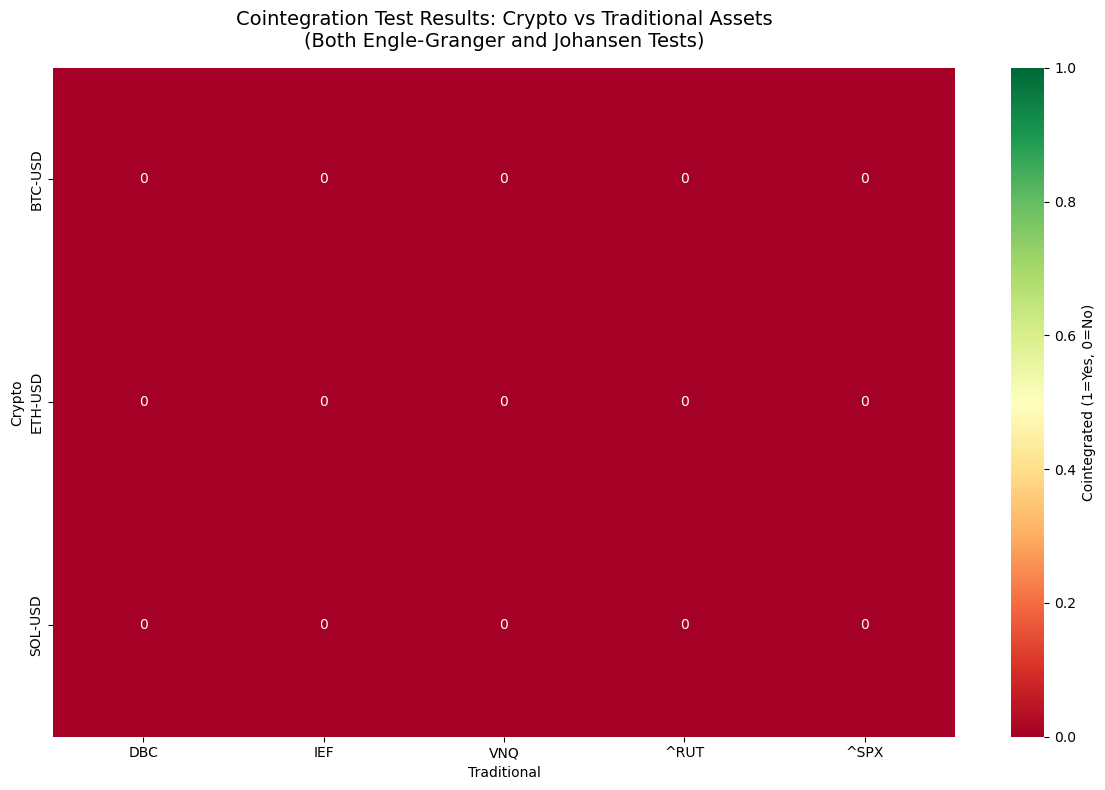

In [25]:
# Create comprehensive cointegration results table
def create_cointegration_table(eg_df, johansen_df):
    """Combine Engle-Granger and Johansen results into comprehensive table"""
    
    # Create table with all pairs
    results = []
    
    for crypto in CRYPTO_ASSETS:
        if crypto not in log_prices.columns:
            continue
        for trad in TRAD_ASSETS:
            if trad not in log_prices.columns:
                continue
            
            # Get Engle-Granger result
            eg_row = eg_df[(eg_df['Crypto'] == crypto) & (eg_df['Traditional'] == trad)]
            
            # Get Johansen result (if available for this crypto)
            joh_row = johansen_df[johansen_df['Crypto'] == crypto] if len(johansen_df) > 0 else pd.DataFrame()
            
            results.append({
                'Crypto': crypto,
                'Traditional': trad,
                'EG_Cointegrated': eg_row['Cointegrated'].values[0] if len(eg_row) > 0 else False,
                'EG_P_Value': eg_row['P_Value'].values[0] if len(eg_row) > 0 else np.nan,
                'EG_Beta': eg_row['Beta'].values[0] if len(eg_row) > 0 else np.nan,
                'Johansen_Cointegrated': joh_row['Cointegrated_Trace'].values[0] if len(joh_row) > 0 else False,
                'Johansen_N_Relationships': joh_row['N_Cointegrating'].values[0] if len(joh_row) > 0 else 0,
                'Both_Tests_Pass': (eg_row['Cointegrated'].values[0] if len(eg_row) > 0 else False) and 
                                  (joh_row['Cointegrated_Trace'].values[0] if len(joh_row) > 0 else False)
            })
    
    return pd.DataFrame(results)

cointegration_summary = create_cointegration_table(eg_df, johansen_df)
print("\n=== Comprehensive Cointegration Results Table ===\n")
print(cointegration_summary.to_string(index=False))

# Save comprehensive table
cointegration_summary.to_csv(os.path.join(TABLE_DIR, "cointegration_summary.csv"), index=False)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))
coint_matrix = cointegration_summary.pivot(index='Crypto', columns='Traditional', values='Both_Tests_Pass')
sns.heatmap(coint_matrix.astype(float), annot=True, fmt='.0f', cmap='RdYlGn', 
            vmin=0, vmax=1, cbar_kws={'label': 'Cointegrated (1=Yes, 0=No)'}, ax=ax)
ax.set_title('Cointegration Test Results: Crypto vs Traditional Assets\n(Both Engle-Granger and Johansen Tests)', fontsize=14, pad=15)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "cointegration_heatmap.png"), dpi=160, bbox_inches='tight')
plt.show()


---

## 4. Regime-Based Analysis

### 4.1 Helper Functions

Functions for tail dependence analysis:
- Quantile correlations
- Conditional Value at Risk (CoVaR)
- Copula tail dependence


In [26]:
# Regime Classification
# 1. VIX-based regimes
def classify_vix_regime(vix_values):
    """Classify market regimes based on VIX levels"""
    regimes = pd.Series(index=vix_values.index, dtype=str)
    regimes[vix_values < 15] = 'Low_Vol'
    regimes[(vix_values >= 15) & (vix_values < 25)] = 'Medium_Vol'
    regimes[vix_values >= 25] = 'High_Vol'
    return regimes

# 2. SPY/SPX drawdown-based regimes
def classify_spy_regime(spy_prices):
    """Classify regimes based on SPY drawdown from peak"""
    # Calculate running peak and drawdown
    running_peak = spy_prices.expanding().max()
    drawdown = (spy_prices / running_peak - 1) * 100  # Percentage drawdown
    
    regimes = pd.Series(index=spy_prices.index, dtype=str)
    regimes[drawdown >= -5] = 'Regime_1'  # Within 5% of peak
    regimes[(drawdown < -5) & (drawdown >= -20)] = 'Regime_2'  # 5-20% drawdown
    regimes[drawdown < -20] = 'Regime_3'  # >20% drawdown
    
    return regimes, drawdown

# Apply regime classification
if '^VIX' in prices.columns:
    vix_series = prices['^VIX']
    if isinstance(vix_series, pd.DataFrame):
        vix_series = vix_series.iloc[:, 0]  # Take first column if DataFrame
    vix_regimes = classify_vix_regime(vix_series)
else:
    vix_regimes = pd.Series(index=prices.index, dtype=str)

if '^SPX' in prices.columns:
    spy_series = prices['^SPX']
    if isinstance(spy_series, pd.DataFrame):
        spy_series = spy_series.iloc[:, 0]  # Take first column if DataFrame
    spy_regimes, spy_drawdown = classify_spy_regime(spy_series)
else:
    spy_regimes = pd.Series(index=prices.index, dtype=str)
    spy_drawdown = pd.Series(index=prices.index)

# Combine regimes
vix_values = prices['^VIX']
if isinstance(vix_values, pd.DataFrame):
    vix_values = vix_values.iloc[:, 0]

spx_values = None
if '^SPX' in prices.columns:
    spx_temp = prices['^SPX']
    if isinstance(spx_temp, pd.DataFrame):
        spx_temp = spx_temp.iloc[:, 0]

regime_df = pd.DataFrame({
    'VIX_Regime': vix_regimes,
    'SPY_Regime': spy_regimes,
    'VIX': vix_values if '^VIX' in prices.columns else np.nan,
    'SPX_Drawdown': spy_drawdown
}, index=prices.index)

# Create combined regime identifier
regime_df['Combined_Regime'] = regime_df['VIX_Regime'] + '_' + regime_df['SPY_Regime']

print("\n=== Regime Classification Summary ===\n")
print("VIX Regimes:")
print(regime_df['VIX_Regime'].value_counts().sort_index())
print("\nSPY/SPX Regimes:")
print(regime_df['SPY_Regime'].value_counts().sort_index())
print("\nCombined Regimes (top 10):")
print(regime_df['Combined_Regime'].value_counts().head(10))

# Save regime data
regime_df.to_csv(os.path.join(TABLE_DIR, "regime_classification.csv"))



=== Regime Classification Summary ===

VIX Regimes:
VIX_Regime
High_Vol      299
Low_Vol       248
Medium_Vol    850
Name: count, dtype: int64

SPY/SPX Regimes:
SPY_Regime
Regime_1    849
Regime_2    492
Regime_3     56
Name: count, dtype: int64

Combined Regimes (top 10):
Combined_Regime
Medium_Vol_Regime_1    556
Medium_Vol_Regime_2    285
Low_Vol_Regime_1       182
High_Vol_Regime_2      141
High_Vol_Regime_1      111
Low_Vol_Regime_2        66
High_Vol_Regime_3       47
Medium_Vol_Regime_3      9
Name: count, dtype: int64


### 4.2 Analysis by Regime

For each market regime, compute:
- **Correlation**: Standard linear correlation
- **Cointegration**: Engle-Granger test results
- **Quantile Correlations**: Tail behavior (Q05, Q95)
- **CoVaR**: Conditional Value at Risk
- **Tail Dependence**: Copula-based tail dependence measures


In [27]:
# Analysis by Regime: Correlation, Cointegration, Tail Dependence

def quantile_correlation(x, y, quantiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]):
    """Calculate correlation at different quantiles"""
    x_ranks = x.rank(pct=True)
    y_ranks = y.rank(pct=True)
    
    results = {}
    for q in quantiles:
        # Select observations where both are in the quantile region
        x_in_quantile = (x_ranks >= q - 0.1) & (x_ranks <= q + 0.1)
        y_in_quantile = (y_ranks >= q - 0.1) & (y_ranks <= q + 0.1)
        both_in = x_in_quantile & y_in_quantile
        
        if both_in.sum() > 10:  # Need sufficient observations
            results[q] = x[both_in].corr(y[both_in])
        else:
            results[q] = np.nan
    
    return results

def covar(x, y, quantile=0.05):
    """Calculate Conditional Value at Risk (CoVaR)
    CoVaR = VaR(y) conditional on x being at its VaR level
    """
    x_var = np.quantile(x.dropna(), quantile)
    y_var = np.quantile(y.dropna(), quantile)
    
    # Filter to tail events
    x_tail = x[x <= x_var]
    y_aligned = y.loc[x_tail.index]
    
    if len(y_aligned) > 5:
        covar_value = np.mean(y_aligned[y_aligned <= y_var]) if len(y_aligned[y_aligned <= y_var]) > 0 else np.nan
    else:
        covar_value = np.nan
    
    return covar_value

def copula_tail_dependence(x, y, tail='lower'):
    """Estimate tail dependence coefficient using empirical copula"""
    # Transform to uniform marginals using ranks
    n = len(x)
    u = (x.rank() - 0.5) / n
    v = (y.rank() - 0.5) / n
    
    k = max(10, int(0.1 * n))  # Use top/bottom 10% or at least 10 observations
    
    if tail == 'lower':
        # Lower tail: P(V < v_k | U < u_k) where u_k = v_k = k/n
        threshold = k / n
        u_tail = u[u < threshold]
        v_tail = v.loc[u_tail.index]
        tail_dep = (v_tail < threshold).sum() / len(u_tail) if len(u_tail) > 0 else np.nan
    else:  # upper tail
        # Upper tail: P(V > v_{n-k} | U > u_{n-k})
        threshold = 1 - k / n
        u_tail = u[u > threshold]
        v_tail = v.loc[u_tail.index]
        tail_dep = (v_tail > threshold).sum() / len(u_tail) if len(u_tail) > 0 else np.nan
    
    return tail_dep

print("Helper functions for tail dependence analysis defined")


Helper functions for tail dependence analysis defined


---

## 5. Visualizations and Summary Tables

### 5.1 Correlation Analysis by Regime

Heatmaps showing correlation matrices for each market regime.


In [28]:
# Analyze by VIX Regime
regime_analysis_results = []

for regime in ['Low_Vol', 'Medium_Vol', 'High_Vol']:
    regime_mask = regime_df['VIX_Regime'] == regime
    # Align returns with regime mask (returns starts one day later due to pct_change)
    # Reindex regime mask to returns index
    regime_mask_aligned = regime_mask.reindex(returns.index).ffill()
    regime_data = returns.loc[regime_mask_aligned].dropna()
    
    if len(regime_data) < 50:  # Need sufficient data
        continue
    
    for crypto in CRYPTO_ASSETS:
        if crypto not in regime_data.columns:
            continue
        for trad in TRAD_ASSETS:
            if trad not in regime_data.columns:
                continue
            
            x = regime_data[crypto].dropna()
            y = regime_data[trad].dropna()
            common_idx = x.index.intersection(y.index)
            x = x.loc[common_idx]
            y = y.loc[common_idx]
            
            if len(x) < 30:
                continue
            
            # Correlation
            corr = x.corr(y)
            
            # Cointegration (Engle-Granger on log prices)
            log_x = log_prices.loc[common_idx, crypto]
            log_y = log_prices.loc[common_idx, trad]
            try:
                eg_result = engle_granger_test(log_x, log_y)
                eg_coint = eg_result['p_value'] < 0.05
            except:
                eg_coint = False
            
            # Quantile correlations
            quant_corrs = quantile_correlation(x, y)
            
            # CoVaR (lower tail)
            covar_val = covar(x, y, quantile=0.05)
            
            # Tail dependence
            lower_tail = copula_tail_dependence(x, y, tail='lower')
            upper_tail = copula_tail_dependence(x, y, tail='upper')
            
            regime_analysis_results.append({
                'Regime_Type': 'VIX',
                'Regime': regime,
                'Crypto': crypto,
                'Traditional': trad,
                'Observations': len(x),
                'Correlation': corr,
                'Cointegrated': eg_coint,
                'Q05_Correlation': quant_corrs.get(0.05, np.nan),
                'Q95_Correlation': quant_corrs.get(0.95, np.nan),
                'CoVaR_Lower': covar_val,
                'Lower_Tail_Dependence': lower_tail,
                'Upper_Tail_Dependence': upper_tail
            })

# Analyze by SPY Regime
for regime in ['Regime_1', 'Regime_2', 'Regime_3']:
    regime_mask = regime_df['SPY_Regime'] == regime
    # Align returns with regime mask
    regime_mask_aligned = regime_mask.reindex(returns.index).ffill()
    regime_data = returns.loc[regime_mask_aligned].dropna()
    
    if len(regime_data) < 50:
        continue
    
    for crypto in CRYPTO_ASSETS:
        if crypto not in regime_data.columns:
            continue
        for trad in TRAD_ASSETS:
            if trad not in regime_data.columns:
                continue
            
            x = regime_data[crypto].dropna()
            y = regime_data[trad].dropna()
            common_idx = x.index.intersection(y.index)
            x = x.loc[common_idx]
            y = y.loc[common_idx]
            
            if len(x) < 30:
                continue
            
            # Correlation
            corr = x.corr(y)
            
            # Cointegration
            log_x = log_prices.loc[common_idx, crypto]
            log_y = log_prices.loc[common_idx, trad]
            try:
                eg_result = engle_granger_test(log_x, log_y)
                eg_coint = eg_result['p_value'] < 0.05
            except:
                eg_coint = False
            
            # Quantile correlations
            quant_corrs = quantile_correlation(x, y)
            
            # CoVaR
            covar_val = covar(x, y, quantile=0.05)
            
            # Tail dependence
            lower_tail = copula_tail_dependence(x, y, tail='lower')
            upper_tail = copula_tail_dependence(x, y, tail='upper')
            
            regime_analysis_results.append({
                'Regime_Type': 'SPY',
                'Regime': regime,
                'Crypto': crypto,
                'Traditional': trad,
                'Observations': len(x),
                'Correlation': corr,
                'Cointegrated': eg_coint,
                'Q05_Correlation': quant_corrs.get(0.05, np.nan),
                'Q95_Correlation': quant_corrs.get(0.95, np.nan),
                'CoVaR_Lower': covar_val,
                'Lower_Tail_Dependence': lower_tail,
                'Upper_Tail_Dependence': upper_tail
            })

regime_analysis_df = pd.DataFrame(regime_analysis_results)
print("\n=== Regime-Based Analysis Results ===\n")
print(regime_analysis_df.head(20).to_string(index=False))

# Save results
regime_analysis_df.to_csv(os.path.join(TABLE_DIR, "regime_analysis_results.csv"), index=False)



=== Regime-Based Analysis Results ===

Regime_Type     Regime  Crypto Traditional  Observations  Correlation  Cointegrated  Q05_Correlation  Q95_Correlation  CoVaR_Lower  Lower_Tail_Dependence  Upper_Tail_Dependence
        VIX    Low_Vol BTC-USD         IEF           248    -0.003259         False              NaN              NaN          NaN               0.041667               0.125000
        VIX    Low_Vol BTC-USD        ^RUT           248     0.255246         False         0.169533        -0.443845    -0.022303               0.250000               0.208333
        VIX    Low_Vol BTC-USD        ^SPX           248     0.139620         False              NaN              NaN    -0.008483               0.166667               0.166667
        VIX    Low_Vol BTC-USD         DBC           248    -0.035630         False              NaN              NaN          NaN               0.083333               0.083333
        VIX    Low_Vol BTC-USD         VNQ           248     0.126458      

### 5.2 Cointegration by Regime

Visualization of cointegration test results across different market regimes.


In [ ]:
# Create visualizations for regime analysis

# 1. Correlation by regime
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# VIX regimes
vix_regimes_list = ['Low_Vol', 'Medium_Vol', 'High_Vol']
for idx, regime in enumerate(vix_regimes_list):
    ax = axes[0, idx]
    data = regime_analysis_df[(regime_analysis_df['Regime_Type'] == 'VIX') & 
                              (regime_analysis_df['Regime'] == regime)]
    
    if len(data) > 0:
        corr_matrix = data.pivot(index='Crypto', columns='Traditional', values='Correlation')
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                   vmin=-1, vmax=1, ax=ax, cbar_kws={'label': 'Correlation'})
        ax.set_title(f'VIX {regime}\nCorrelation Matrix', fontsize=12)

# SPY regimes
spy_regimes_list = ['Regime_1', 'Regime_2', 'Regime_3']
regime_labels = ['SPY ≥ -5% DD', 'SPY -5% to -20% DD', 'SPY < -20% DD']
for idx, (regime, label) in enumerate(zip(spy_regimes_list, regime_labels)):
    ax = axes[1, idx]
    data = regime_analysis_df[(regime_analysis_df['Regime_Type'] == 'SPY') & 
                              (regime_analysis_df['Regime'] == regime)]
    
    if len(data) > 0:
        corr_matrix = data.pivot(index='Crypto', columns='Traditional', values='Correlation')
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                   vmin=-1, vmax=1, ax=ax, cbar_kws={'label': 'Correlation'})
        ax.set_title(f'{label}\nCorrelation Matrix', fontsize=12)

plt.suptitle('Correlation Analysis by Market Regime', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "correlation_by_regime.png"), dpi=160, bbox_inches='tight')
plt.show()


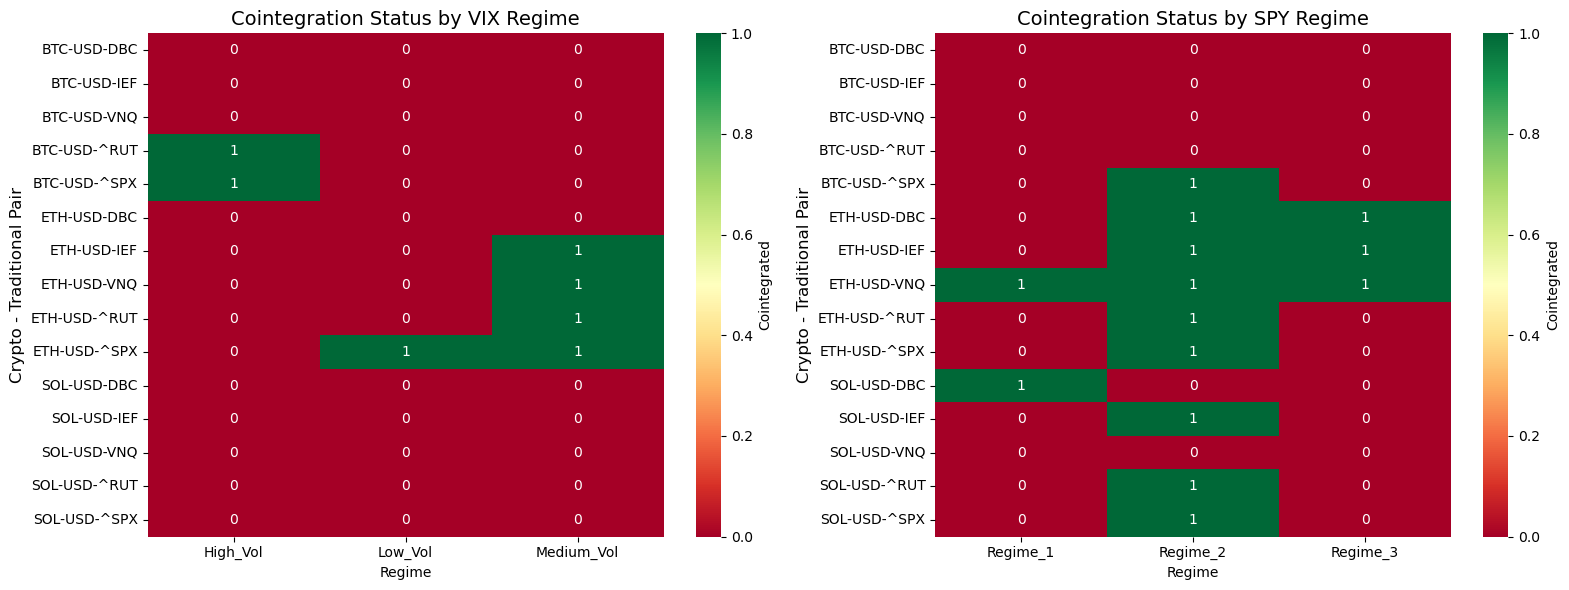

In [ ]:
# 2. Cointegration by regime
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# VIX regimes
ax = axes[0]
vix_coint = regime_analysis_df[(regime_analysis_df['Regime_Type'] == 'VIX')].groupby(['Regime', 'Crypto', 'Traditional'])['Cointegrated'].first().reset_index()
vix_coint_pivot = vix_coint.pivot_table(index=['Crypto', 'Traditional'], columns='Regime', values='Cointegrated', aggfunc='first')
vix_coint_pivot = vix_coint_pivot.astype(float)
sns.heatmap(vix_coint_pivot, annot=True, fmt='.0f', cmap='RdYlGn', vmin=0, vmax=1,
           ax=ax, cbar_kws={'label': 'Cointegrated'})
ax.set_title('Cointegration Status by VIX Regime', fontsize=14)
ax.set_ylabel('Crypto - Traditional Pair', fontsize=12)

# SPY regimes
ax = axes[1]
spy_coint = regime_analysis_df[(regime_analysis_df['Regime_Type'] == 'SPY')].groupby(['Regime', 'Crypto', 'Traditional'])['Cointegrated'].first().reset_index()
spy_coint_pivot = spy_coint.pivot_table(index=['Crypto', 'Traditional'], columns='Regime', values='Cointegrated', aggfunc='first')
spy_coint_pivot = spy_coint_pivot.astype(float)
sns.heatmap(spy_coint_pivot, annot=True, fmt='.0f', cmap='RdYlGn', vmin=0, vmax=1,
           ax=ax, cbar_kws={'label': 'Cointegrated'})
ax.set_title('Cointegration Status by SPY Regime', fontsize=14)
ax.set_ylabel('Crypto - Traditional Pair', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "cointegration_by_regime.png"), dpi=160, bbox_inches='tight')
plt.show()


### 5.3 Tail Dependence Analysis

Copula-based tail dependence coefficients showing the probability of extreme co-movements in the lower and upper tails.


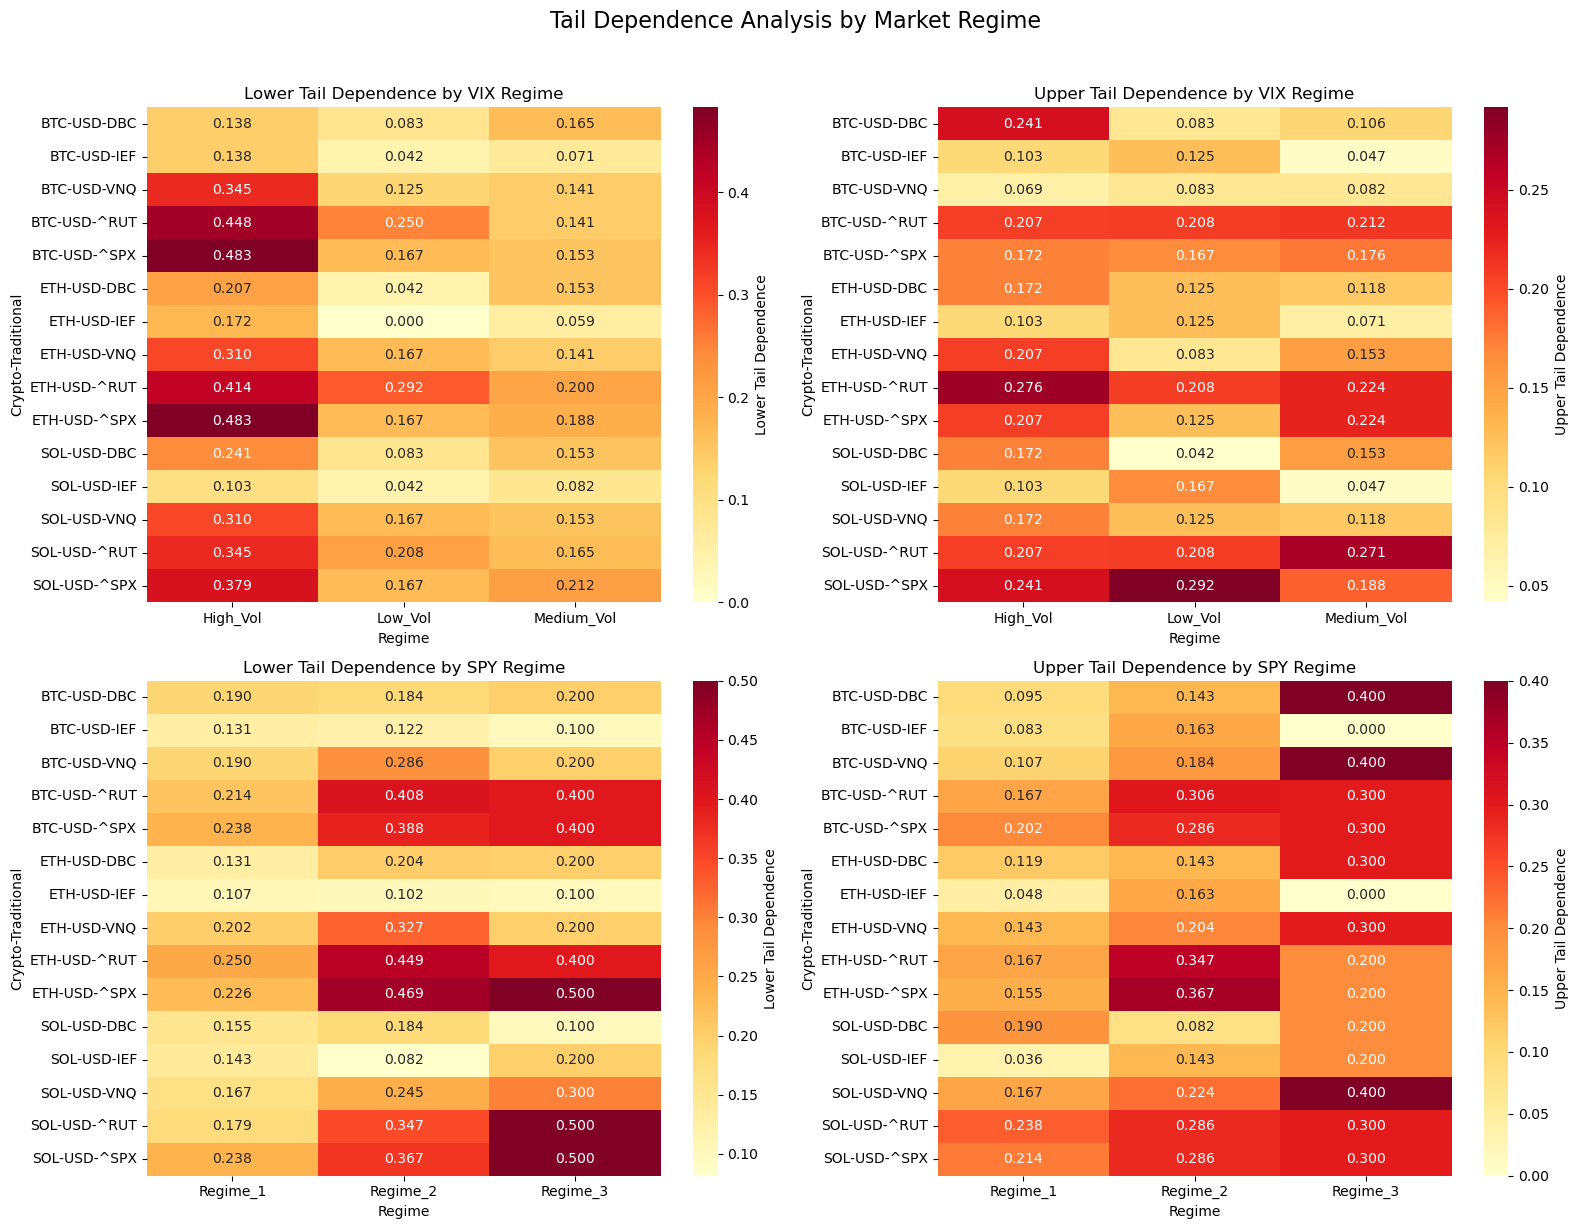

In [ ]:
# 3. Tail Dependence Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Lower tail dependence by VIX regime
ax = axes[0, 0]
vix_lower_tail = regime_analysis_df[(regime_analysis_df['Regime_Type'] == 'VIX')].groupby(['Regime', 'Crypto', 'Traditional'])['Lower_Tail_Dependence'].first().reset_index()
if len(vix_lower_tail) > 0:
    vix_lower_pivot = vix_lower_tail.pivot_table(index=['Crypto', 'Traditional'], columns='Regime', 
                                                 values='Lower_Tail_Dependence', aggfunc='mean')
    sns.heatmap(vix_lower_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax, 
               cbar_kws={'label': 'Lower Tail Dependence'})
    ax.set_title('Lower Tail Dependence by VIX Regime', fontsize=12)

# Upper tail dependence by VIX regime
ax = axes[0, 1]
vix_upper_tail = regime_analysis_df[(regime_analysis_df['Regime_Type'] == 'VIX')].groupby(['Regime', 'Crypto', 'Traditional'])['Upper_Tail_Dependence'].first().reset_index()
if len(vix_upper_tail) > 0:
    vix_upper_pivot = vix_upper_tail.pivot_table(index=['Crypto', 'Traditional'], columns='Regime', 
                                                 values='Upper_Tail_Dependence', aggfunc='mean')
    sns.heatmap(vix_upper_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax,
               cbar_kws={'label': 'Upper Tail Dependence'})
    ax.set_title('Upper Tail Dependence by VIX Regime', fontsize=12)

# Lower tail dependence by SPY regime
ax = axes[1, 0]
spy_lower_tail = regime_analysis_df[(regime_analysis_df['Regime_Type'] == 'SPY')].groupby(['Regime', 'Crypto', 'Traditional'])['Lower_Tail_Dependence'].first().reset_index()
if len(spy_lower_tail) > 0:
    spy_lower_pivot = spy_lower_tail.pivot_table(index=['Crypto', 'Traditional'], columns='Regime', 
                                                 values='Lower_Tail_Dependence', aggfunc='mean')
    sns.heatmap(spy_lower_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax,
               cbar_kws={'label': 'Lower Tail Dependence'})
    ax.set_title('Lower Tail Dependence by SPY Regime', fontsize=12)

# Upper tail dependence by SPY regime
ax = axes[1, 1]
spy_upper_tail = regime_analysis_df[(regime_analysis_df['Regime_Type'] == 'SPY')].groupby(['Regime', 'Crypto', 'Traditional'])['Upper_Tail_Dependence'].first().reset_index()
if len(spy_upper_tail) > 0:
    spy_upper_pivot = spy_upper_tail.pivot_table(index=['Crypto', 'Traditional'], columns='Regime', 
                                                 values='Upper_Tail_Dependence', aggfunc='mean')
    sns.heatmap(spy_upper_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax,
               cbar_kws={'label': 'Upper Tail Dependence'})
    ax.set_title('Upper Tail Dependence by SPY Regime', fontsize=12)

plt.suptitle('Tail Dependence Analysis by Market Regime', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "tail_dependence_by_regime.png"), dpi=160, bbox_inches='tight')
plt.show()


### 5.4 Quantile Correlations

Comparison of correlations at different quantiles (Q05 vs Q95) to assess tail behavior differences across regimes.


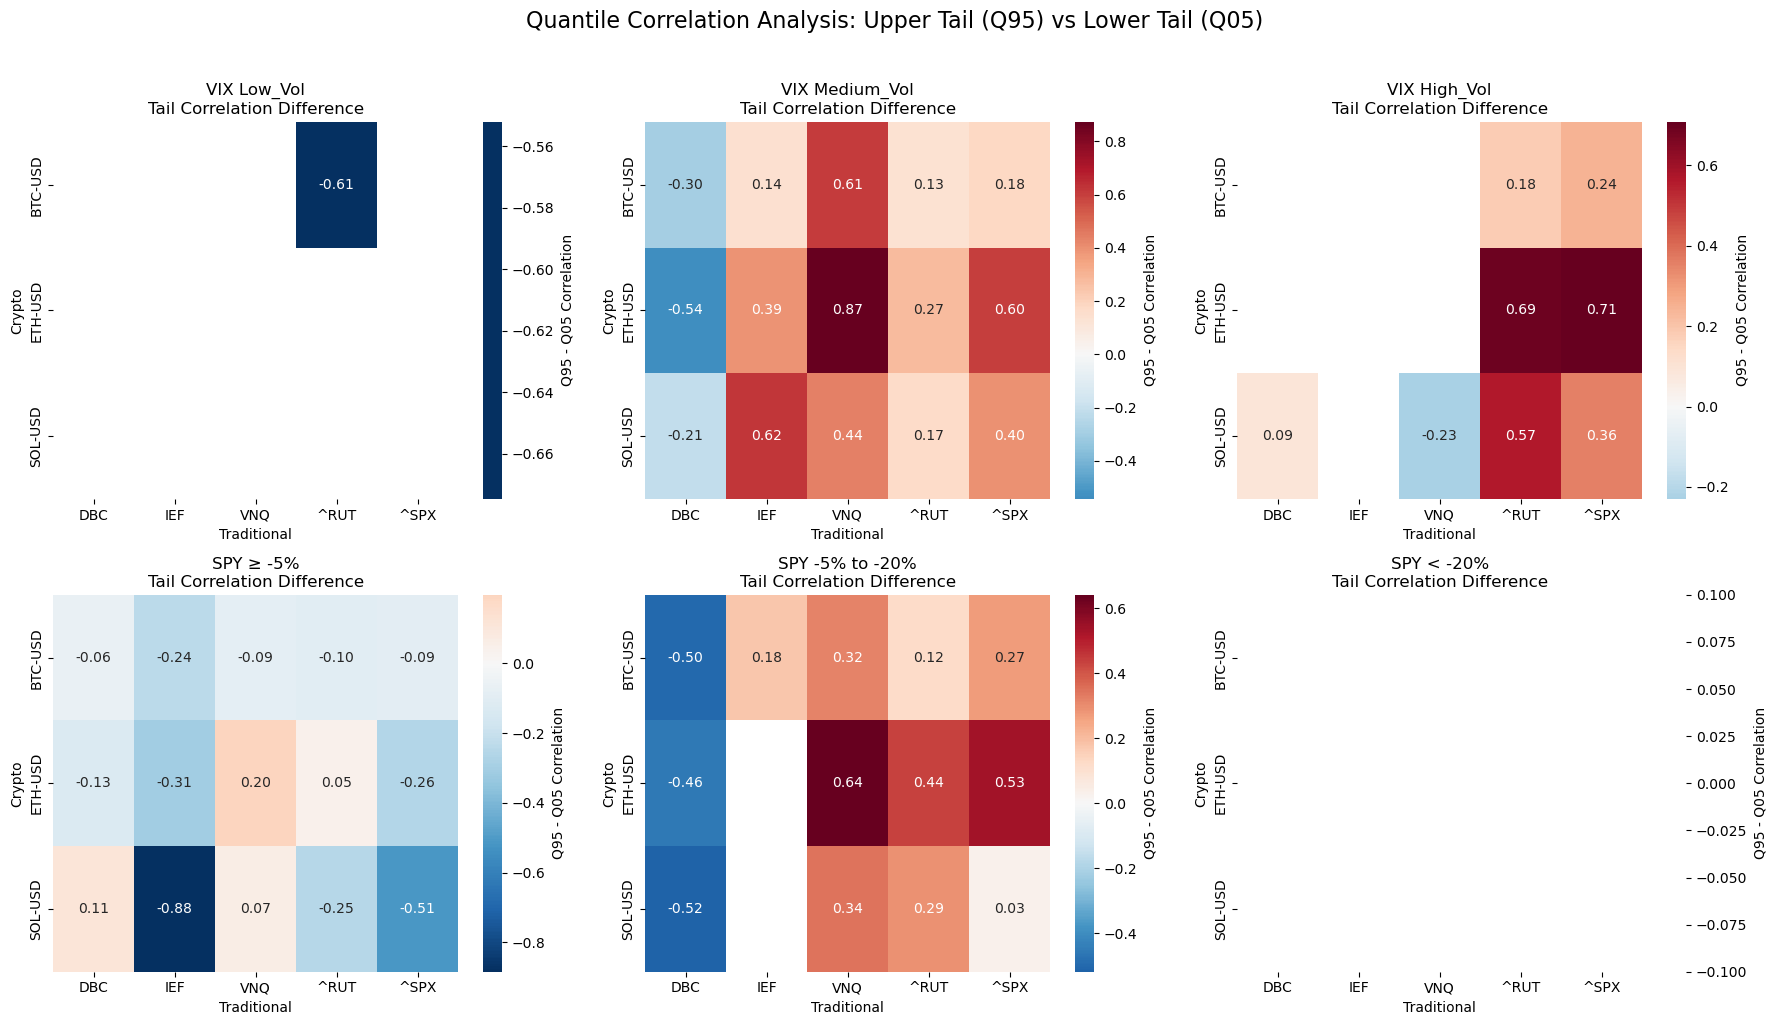

In [ ]:
# 4. Quantile Correlations Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# VIX regimes - quantile correlations
for idx, regime in enumerate(['Low_Vol', 'Medium_Vol', 'High_Vol']):
    ax = axes[0, idx]
    data = regime_analysis_df[(regime_analysis_df['Regime_Type'] == 'VIX') & 
                              (regime_analysis_df['Regime'] == regime)]
    
    if len(data) > 0:
        # Get Q05 and Q95 correlations
        q05_data = data.pivot(index='Crypto', columns='Traditional', values='Q05_Correlation')
        q95_data = data.pivot(index='Crypto', columns='Traditional', values='Q95_Correlation')
        
        # Plot difference (tail vs middle)
        diff_data = q95_data - q05_data  # Upper tail minus lower tail
        sns.heatmap(diff_data, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                   ax=ax, cbar_kws={'label': 'Q95 - Q05 Correlation'})
        ax.set_title(f'VIX {regime}\nTail Correlation Difference', fontsize=12)

# SPY regimes - quantile correlations
for idx, (regime, label) in enumerate(zip(['Regime_1', 'Regime_2', 'Regime_3'], 
                                          ['SPY ≥ -5%', 'SPY -5% to -20%', 'SPY < -20%'])):
    ax = axes[1, idx]
    data = regime_analysis_df[(regime_analysis_df['Regime_Type'] == 'SPY') & 
                              (regime_analysis_df['Regime'] == regime)]
    
    if len(data) > 0:
        q05_data = data.pivot(index='Crypto', columns='Traditional', values='Q05_Correlation')
        q95_data = data.pivot(index='Crypto', columns='Traditional', values='Q95_Correlation')
        
        diff_data = q95_data - q05_data
        sns.heatmap(diff_data, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                   ax=ax, cbar_kws={'label': 'Q95 - Q05 Correlation'})
        ax.set_title(f'{label}\nTail Correlation Difference', fontsize=12)

plt.suptitle('Quantile Correlation Analysis: Upper Tail (Q95) vs Lower Tail (Q05)', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "quantile_correlations_by_regime.png"), dpi=160, bbox_inches='tight')
plt.show()


### 5.5 CoVaR (Conditional Value at Risk) Analysis

Conditional Value at Risk measures showing the expected loss of one asset when another is in its tail region.


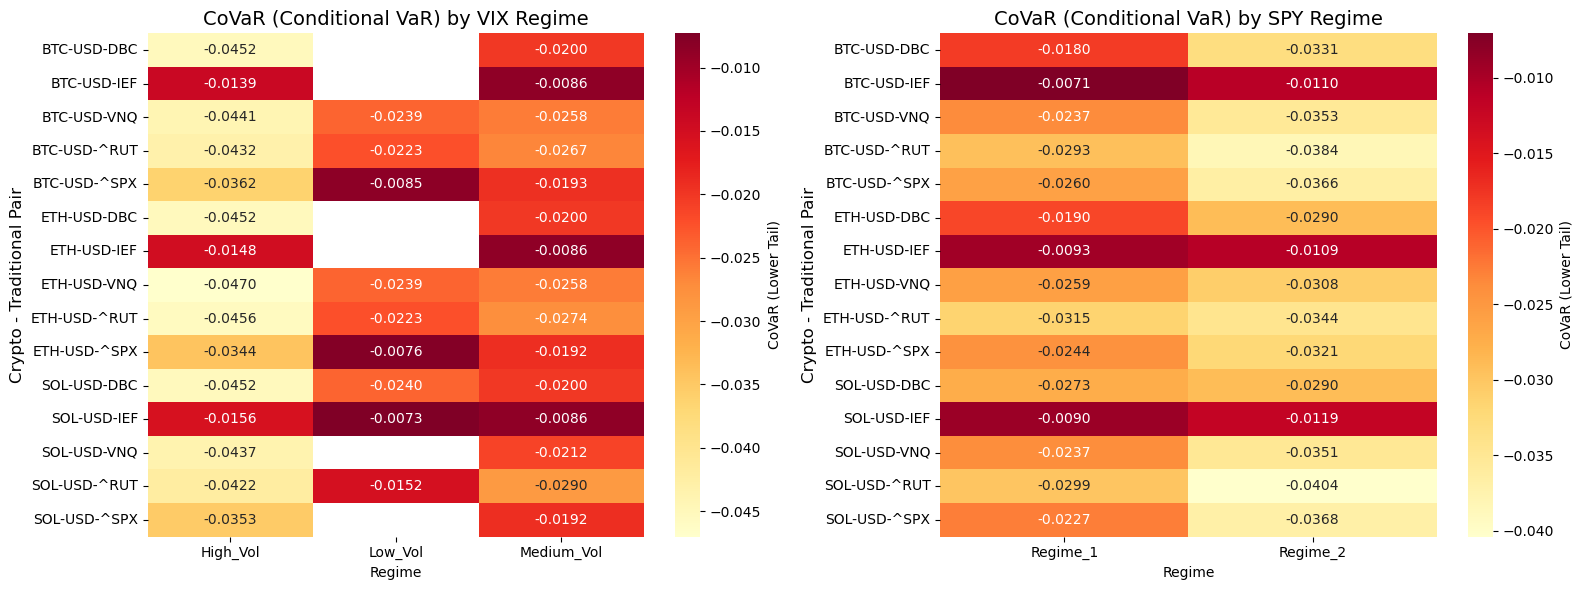

In [ ]:
# 5. CoVaR Analysis Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# VIX regimes - CoVaR
ax = axes[0]
vix_covar = regime_analysis_df[(regime_analysis_df['Regime_Type'] == 'VIX')].groupby(['Regime', 'Crypto', 'Traditional'])['CoVaR_Lower'].first().reset_index()
if len(vix_covar) > 0:
    covar_pivot = vix_covar.pivot_table(index=['Crypto', 'Traditional'], columns='Regime', 
                                       values='CoVaR_Lower', aggfunc='mean')
    sns.heatmap(covar_pivot, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax,
               cbar_kws={'label': 'CoVaR (Lower Tail)'})
    ax.set_title('CoVaR (Conditional VaR) by VIX Regime', fontsize=14)
    ax.set_ylabel('Crypto - Traditional Pair', fontsize=12)

# SPY regimes - CoVaR
ax = axes[1]
spy_covar = regime_analysis_df[(regime_analysis_df['Regime_Type'] == 'SPY')].groupby(['Regime', 'Crypto', 'Traditional'])['CoVaR_Lower'].first().reset_index()
if len(spy_covar) > 0:
    covar_pivot = spy_covar.pivot_table(index=['Crypto', 'Traditional'], columns='Regime', 
                                       values='CoVaR_Lower', aggfunc='mean')
    sns.heatmap(covar_pivot, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax,
               cbar_kws={'label': 'CoVaR (Lower Tail)'})
    ax.set_title('CoVaR (Conditional VaR) by SPY Regime', fontsize=14)
    ax.set_ylabel('Crypto - Traditional Pair', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "covar_by_regime.png"), dpi=160, bbox_inches='tight')
plt.show()


In [ ]:
# Create summary tables for easy interpretation

# Summary table 1: Cointegration results across all regimes
summary_coint = regime_analysis_df.groupby(['Regime_Type', 'Regime', 'Crypto', 'Traditional']).agg({
    'Cointegrated': 'first',
    'Correlation': 'mean',
    'Lower_Tail_Dependence': 'mean',
    'Upper_Tail_Dependence': 'mean',
    'CoVaR_Lower': 'mean',
    'Observations': 'sum'
}).reset_index()

summary_coint_pivot = summary_coint.pivot_table(
    index=['Crypto', 'Traditional'],
    columns=['Regime_Type', 'Regime'],
    values=['Cointegrated', 'Correlation'],
    aggfunc='first'
)

print("\n=== Summary: Cointegration Status by Regime ===\n")
print(summary_coint_pivot['Cointegrated'].to_string())

# Save summary
summary_coint_pivot['Cointegrated'].to_csv(os.path.join(TABLE_DIR, "cointegration_by_regime_summary.csv"))
summary_coint_pivot['Correlation'].to_csv(os.path.join(TABLE_DIR, "correlation_by_regime_summary.csv"))

# Summary table 2: Tail dependence comparison
tail_summary = regime_analysis_df.groupby(['Regime_Type', 'Regime']).agg({
    'Lower_Tail_Dependence': 'mean',
    'Upper_Tail_Dependence': 'mean',
    'Correlation': 'mean'
}).reset_index()

print("\n=== Summary: Average Tail Dependence and Correlation by Regime ===\n")
print(tail_summary.to_string(index=False))

tail_summary.to_csv(os.path.join(TABLE_DIR, "tail_dependence_summary.csv"), index=False)

print("\n\n=== Analysis Complete ===")
print(f"All results saved to {OUT_DIR}/")
print("\nGenerated files:")
print("  Tables:")
print("    - cointegration_summary.csv")
print("    - engle_granger_results.csv")
print("    - johansen_results.csv")
print("    - regime_analysis_results.csv")
print("    - regime_classification.csv")
print("    - cointegration_by_regime_summary.csv")
print("    - correlation_by_regime_summary.csv")
print("    - tail_dependence_summary.csv")
print("\n  Figures:")
print("    - cointegration_heatmap.png")
print("    - correlation_by_regime.png")
print("    - cointegration_by_regime.png")
print("    - tail_dependence_by_regime.png")
print("    - quantile_correlations_by_regime.png")
print("    - covar_by_regime.png")



=== Summary: Cointegration Status by Regime ===

Regime_Type              SPY                        VIX                   
Regime              Regime_1 Regime_2 Regime_3 High_Vol Low_Vol Medium_Vol
Crypto  Traditional                                                       
BTC-USD DBC            False    False    False    False   False      False
        IEF            False    False    False    False   False      False
        VNQ            False    False    False    False   False      False
        ^RUT           False    False    False     True   False      False
        ^SPX           False     True    False     True   False      False
ETH-USD DBC            False     True     True    False   False      False
        IEF            False     True     True    False   False       True
        VNQ             True     True     True    False   False       True
        ^RUT           False     True    False    False   False       True
        ^SPX           False     True    False    

---

## 6. Summary Tables

Aggregated summary tables for easy interpretation of results across all regimes.


---

## Analysis Complete

All tables and figures have been generated and saved to the `outputs/` directory. Review the summary tables and visualizations above to draw conclusions about:

1. **Long-run equilibrium relationships** between crypto assets and traditional asset classes
2. **Regime stability** of these relationships across different market conditions
3. **Tail dependence patterns** that reveal extreme co-movement behavior
